In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

In [4]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/10/01 12:59:24 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/10/01 12:59:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 12:59:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# base_path = "/data/saturation/thesis_run_20240726_single_sims/"
base_path = "/data/saturation/thesis_run_20240929/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 16

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [ ]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [7]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    simulation_ids = data.simulation_id.drop_duplicates()
    for idx, simulation_id in enumerate(simulation_ids):
        data_subset = data[data.simulation_id == simulation_id].sort_values("ntot")
        ax.plot(
            data_subset[x_var],
            data_subset[y_var],
            c=colors[idx % len(colors)],
            ls=line_styles[idx % len(line_styles)]
        )

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig


def plot_metrics(
    *,
    df: pd.DataFrame,
    scenario_name: str,
    ntot_bound_saturation: int,
    show_plots: bool = False
):
    ad_line = df[df.ntot > ntot_bound_saturation].ad.mean()
    print(f"AD line: {ad_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "ad",
        "$A_d$",
        dotted_horizontal_lines=[ad_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_ad.png", bbox_inches="tight")
    
    log_mnnd_line = df[df.ntot > ntot_bound_saturation].log_mnnd.mean()
    print(f"log_mnnd line: {log_mnnd_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "log_mnnd",
        "$log_{10}(\\overline{NN}_d)$",
        dotted_horizontal_lines=[log_mnnd_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_mnnd.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "z",
        "$Z$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_z.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "za",
        "$Z_a$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_za.png", bbox_inches="tight")
    
    radius_mean_line = df[df.ntot > ntot_bound_saturation].radius_mean.mean()
    print(f"radius_mean line: {radius_mean_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_mean",
        "$\\overline{r}$",
        dotted_horizontal_lines=[radius_mean_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_mean.png", bbox_inches="tight")
    
    radius_stdev_line = df[df.ntot > ntot_bound_saturation].radius_stdev.mean()
    print(f"radius_stdev line: {radius_stdev_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_stdev",
        "$\\sigma_r$",
        dotted_horizontal_lines=[radius_stdev_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_stdev.png", bbox_inches="tight")


def plot_slope_estimates(estimates_df: pd.DataFrame):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    ax.errorbar(
        estimates_df.ntot,
        estimates_df.alpha,
        estimates_df.sigma,
        ls="None",
        marker="+"
    )
    ax.set_xlabel("$N_{tot}$", fontsize=font_size)
    ax.set_ylabel("$b$", fontsize=font_size)
    ax.set_xscale("log")
    
    return fig

# Comparisons of scenarios

## Shallow slope

In [26]:
scenario_name = "shallow_slope"
selected_slope = -1
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
58,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,1,-1.0,250,2000


nobs line: 392.5


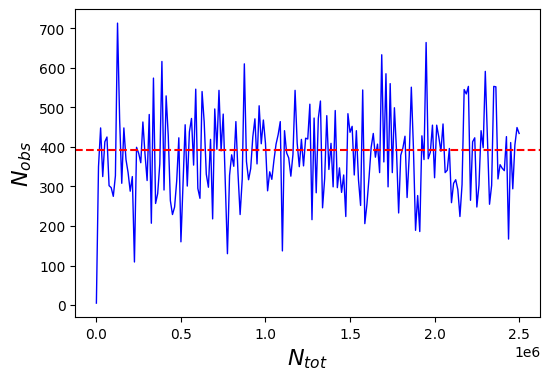

In [27]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

nobs line: 369.0


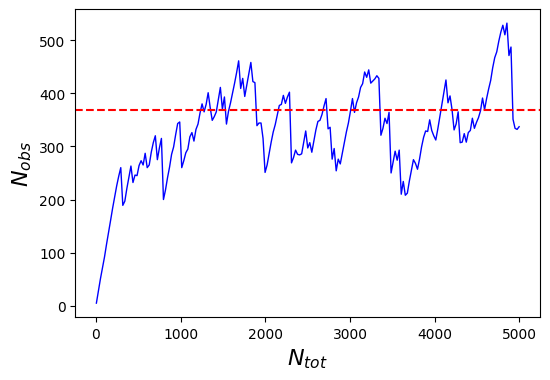

In [28]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

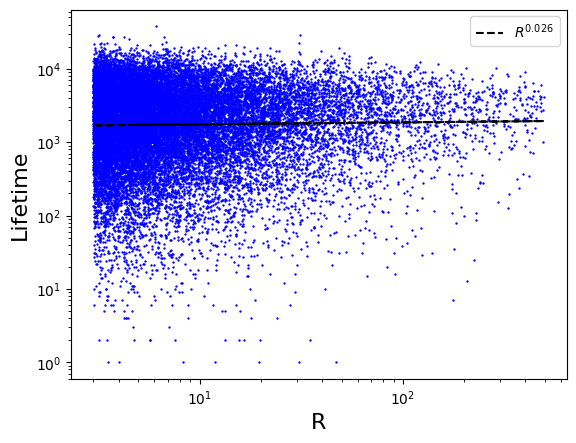

<Figure size 640x480 with 0 Axes>

In [15]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [16]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     916.3
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          3.01e-201
Time:                        13:01:19   Log-Likelihood:            -4.1403e+06
No. Observations:             2502080   AIC:                         8.281e+06
Df Residuals:                 2502078   BIC:                         8.281e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.4070      0.002   3753.490      0.000       7.403       7.411
np.log(radius)     0.0264      0.001     30.271      0.000       0.025       0.028
==============================================================================
Omnibus:                   468217.801   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           969689.471
Skew:                          -1.115   Prob(JB):                         0.00
Kurtosis:                       5.080   Cond. No.                         6.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

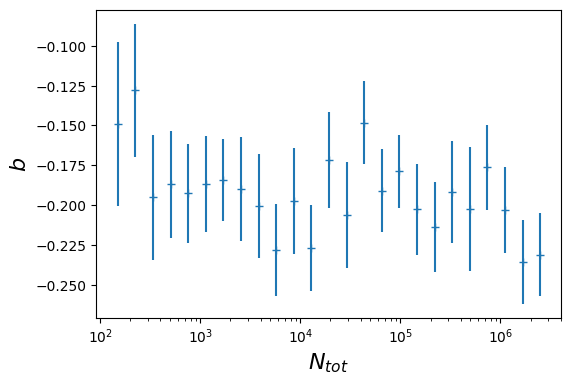

In [18]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=2.5*10**6)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

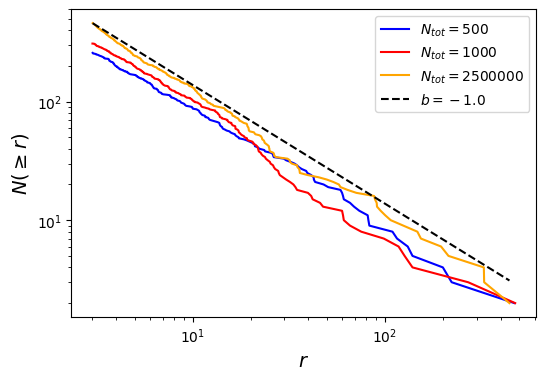

In [22]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 1000, int(2.5*10**6)], spark=spark)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Steep slope

In [24]:
scenario_name = "steep_slope"
selected_slope = -4
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
57,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9,-4.0,250,2000
68,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8,-4.0,250,2000
69,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7,-4.0,250,2000
110,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,10,-4.0,250,2000


nobs line: 557.0


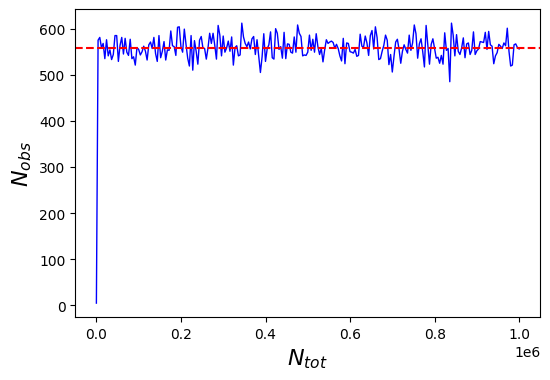

In [17]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$R^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [19]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 3.364e+05
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:47:02   Log-Likelihood:            -1.4007e+05
No. Observations:              250059   AIC:                         2.801e+05
Df Residuals:                  250057   BIC:                         2.802e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.6014      0.005   2673.305      0.000      12.592      12.611
np.log(radius)     1.9962      0.003    580.002      0.000       1.989       2.003
==============================================================================
Omnibus:                    98834.608   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1544230.388
Skew:                          -1.485   Prob(JB):                         0.00
Kurtosis:                      14.806   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

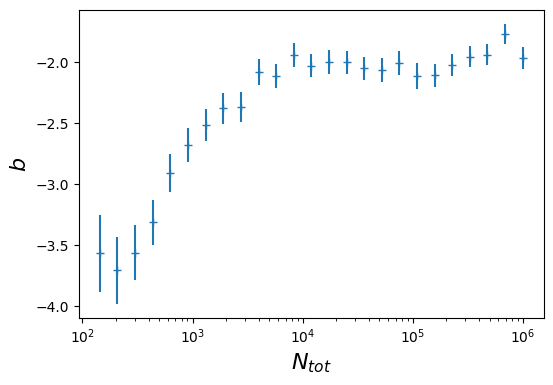

In [20]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

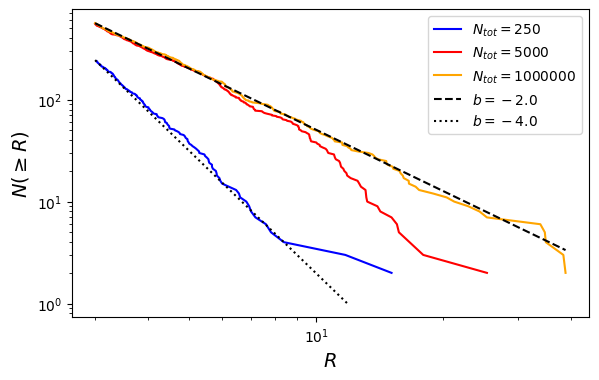

In [21]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[250, 5000, 25000000], spark=spark)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## High destruction, b = -2.5

In [29]:
scenario_name = "high_destruction"
selected_slope = -2.5
selected_mrp = 0.75
selected_rmult = 1.9

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
51,0.75,"{'name': 'radius_ratio', 'ratio': '11.0'}",1.9,3,-2.5,250,2000


nobs line: 1314.5


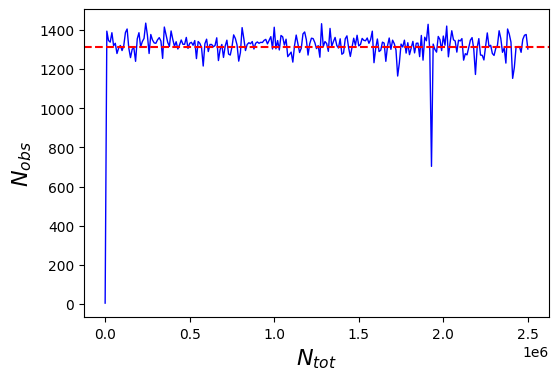

In [30]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue",
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

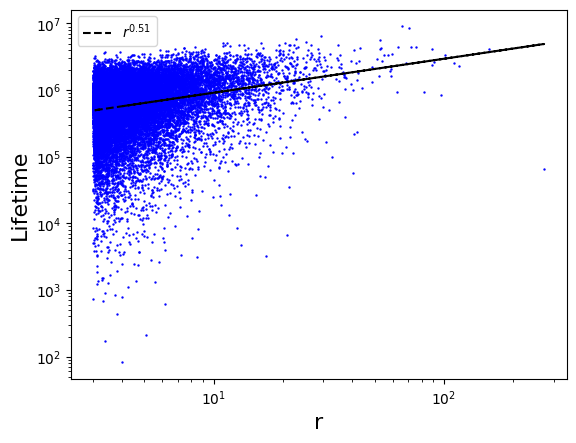

<Figure size 640x480 with 0 Axes>

In [31]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [32]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.250e+05
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:22:48   Log-Likelihood:            -3.3154e+06
No. Observations:             2501180   AIC:                         6.631e+06
Df Residuals:                 2501178   BIC:                         6.631e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5493      0.002   5611.001      0.000      12.545      12.554
np.log(radius)     0.5100      0.001    353.600      0.000       0.507       0.513
==============================================================================
Omnibus:                   921017.545   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4759554.540
Skew:                          -1.713   Prob(JB):                         0.00
Kurtosis:                       8.825   Cond. No.                         8.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

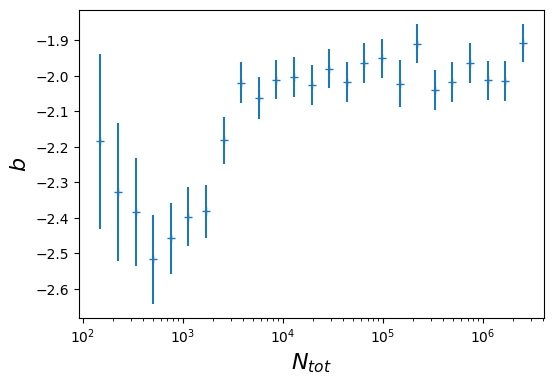

In [42]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=2500000)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

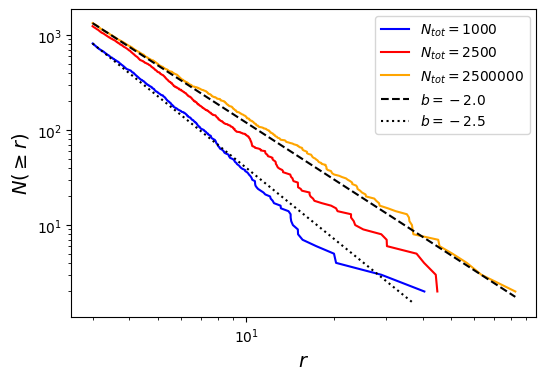

In [43]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[1000, 2500, 2500000], spark=spark)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Low destruction, slope = -2.5

Ntot/nobs plot and Z/Za plots restricted in range to show Z/Za reaching significance before "saturation"

In [44]:
scenario_name = "low_destruction"
selected_slope = -2.5
selected_mrp = 0.25
selected_rmult = 1.1

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
111,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,4,-2.5,250,2000


nobs line: 24978.0


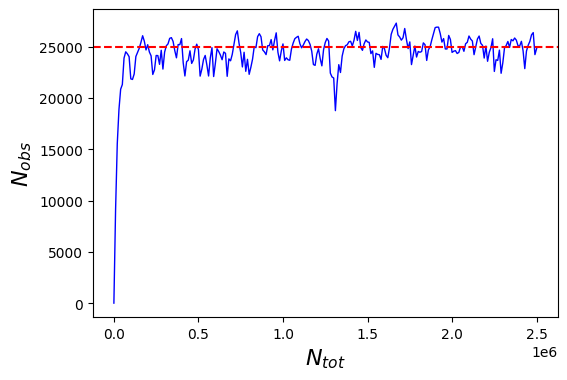

In [46]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

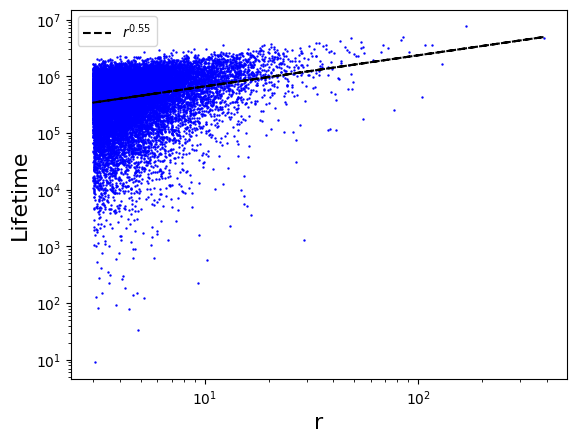

<Figure size 640x480 with 0 Axes>

In [47]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [54]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:35:19   Log-Likelihood:            -3.4432e+06
No. Observations:             2477696   AIC:                         6.886e+06
Df Residuals:                 2477694   BIC:                         6.886e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1455      0.002   5061.808      0.000      12.141      12.150
np.log(radius)     0.5480      0.002    353.865      0.000       0.545       0.551
==============================================================================
Omnibus:                   993110.985   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5220386.408
Skew:                          -1.885   Prob(JB):                         0.00
Kurtosis:                       9.030   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

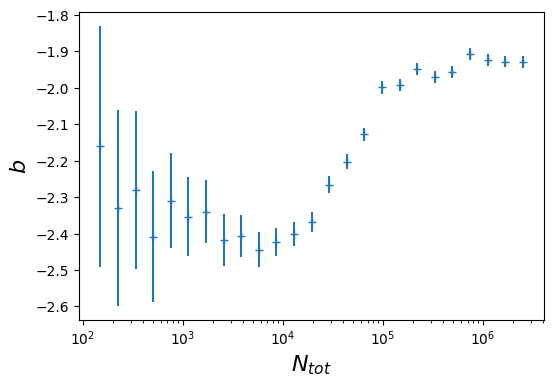

In [56]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=2500000)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

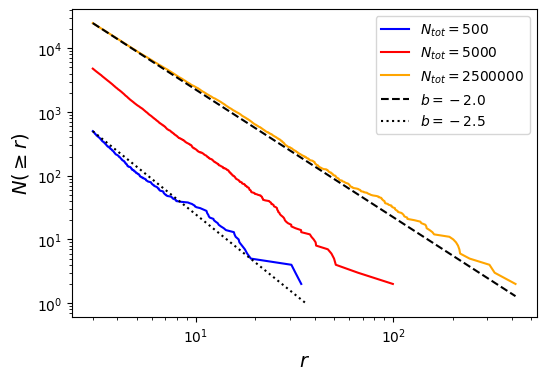

In [57]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 5000, 2500000], spark=spark)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, shallow slope

In [92]:
scenario_name = "no_erasure_threshold_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 5	

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
71,0.5,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,5,-1.0,250,2000


nobs line: 877.0


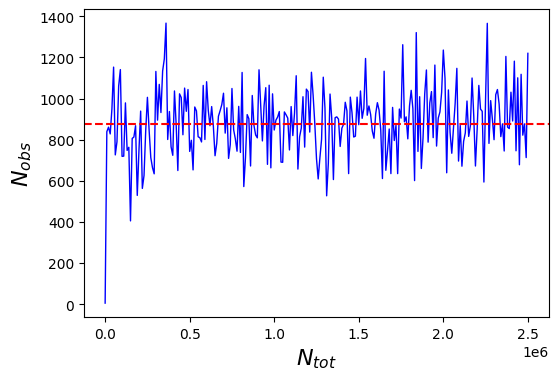

In [93]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

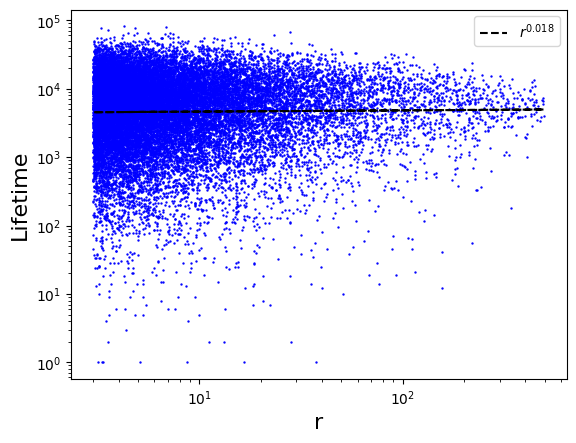

<Figure size 640x480 with 0 Axes>

In [94]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [95]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     428.2
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           4.13e-95
Time:                        14:16:02   Log-Likelihood:            -4.1243e+06
No. Observations:             2501306   AIC:                         8.249e+06
Df Residuals:                 2501304   BIC:                         8.249e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.3985      0.002   4277.919      0.000       8.395       8.402
np.log(radius)     0.0180      0.001     20.692      0.000       0.016       0.020
==============================================================================
Omnibus:                   497157.065   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1106235.168
Skew:                          -1.147   Prob(JB):                         0.00
Kurtosis:                       5.313   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

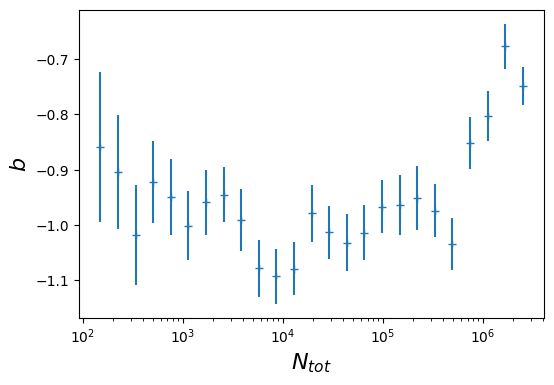

In [96]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=2500000)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

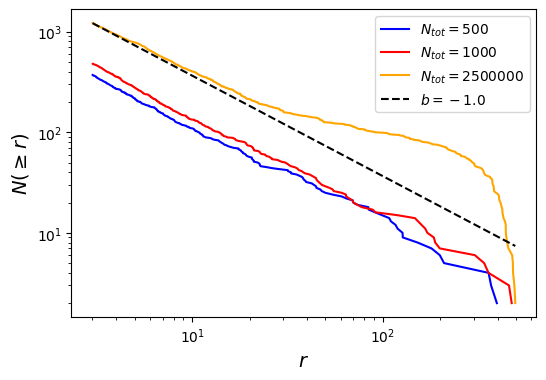

In [97]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 1000, int(2.5*10**6)], spark=spark)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, steep slope

In [87]:
scenario_name = "no_erasure_threshold_steep_slope"
selected_slope = -4.0
selected_simulation_id = 6

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size


In [ ]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=2500000)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 1000, int(2.5*10**6)], spark=spark)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Extended simulation, shallow slope

In [ ]:
scenario_name = "long_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 135

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

In [ ]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 1.0, spark)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.2} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [ ]:
fitted_model.summary()

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, spark=spark, max_ntot=50000000)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 100000, int(5e7)])

equilibrium_slope = -1.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")